In [1]:
import azureml.core
from azureml.core import Workspace, Datastore
import pandas as pd
from azureml.contrib.automl.pipeline.steps import AutoMLPipelineBuilder
from azureml.pipeline.core import Pipeline
# Set up your workspace
ws = Workspace.from_config()
ws.get_details()

# Set up your datastores
dstore = ws.get_default_datastore()

output = {}
output["SDK version"] = azureml.core.VERSION
output["Subscription ID"] = ws.subscription_id
output["Workspace"] = ws.name
output["Resource Group"] = ws.resource_group
output["Location"] = ws.location
output["Default datastore name"] = dstore.name
pd.set_option("display.max_colwidth", None)
outputDf = pd.DataFrame(data=output, index=[""])
outputDf.T
import warnings 
warnings.filterwarnings("ignore")
# setup azure workspace for heireacheal forecasting 

2022-05-19:19:06:09,969 INFO     [modeling_bert.py:226] Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .
2022-05-19:19:06:09,975 INFO     [modeling_xlnet.py:339] Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .
2022-05-19:19:06:11,172 INFO     [workspace.py:290] Found the config file in: /config.json
2022-05-19:19:06:12,182 INFO     [_universal.py:475] Request URL: 'https://management.azure.com/subscriptions?api-version=REDACTED'/nRequest method: 'GET'/nRequest headers:/n    'Accept': 'application/json'/n    'x-ms-client-request-id': 'bf5a39e0-d7a6-11ec-8ea8-d3bd16baa39a'/n    'User-Agent': 'azsdk-python-azure-mgmt-resource/20.1.0 Python/3.8.5 (Linux-5.4.0-1073-azure-x86_64-with-glibc2.10)'/n    'Authorization': 'REDACTED'/nNo body was attached to the request
2022-05-19:19:06:12,262 INFO     [_universal.py:503] Response status: 200/nResponse headers:/n    'Cache-Control': 'no-cache'/n    'Pragma': 'no-c

In [2]:
from azureml.core import Experiment

experiment = Experiment(ws, "automl-hts-OnRent")

print("Experiment name: " + experiment.name)

2022-05-19:19:06:12,792 INFO     [clientbase.py:192] Created a worker pool for first use


Experiment name: automl-hts-OnRent


In [3]:
datastore_path = "hts-sample-OnRent"

In [4]:
datastore = ws.get_default_datastore()
datastore

2022-05-19:19:06:12,882 INFO     [datastore_client.py:908] <azureml.core.authentication.InteractiveLoginAuthentication object at 0x7f495dfc1850>


{
  "name": "workspaceblobstore",
  "container_name": "azureml-blobstore-f98b1666-fb10-4642-8f15-3e39c0354668",
  "account_name": "tmazworkspace5627775817",
  "protocol": "https",
  "endpoint": "core.windows.net"
}

In [5]:
date_column ='EffectiveDate'
file_location = 'FleetForecasting_Top100ProductSubCategory_WithIHSData_Weather_BYDay_V2.csv'
input_data_raw=pd.read_csv(file_location ,sep ='|',parse_dates=[date_column])
input_data_copy = input_data_raw.copy()

In [6]:
input_data_copy.Region.unique()

array([  1,  11,  12, 900, 700,  14, 200, 300, 400, 500, 600, 800,  10])

In [7]:
input_data_copy.RegionName.unique()

array(['REGION 01                     ', 'REGION 11                     ',
       'REGION 12                     ', 'REGION 09                     ',
       'REGION 07                     ', 'REGION 14                     ',
       'REGION 02                     ', 'REGION 03                     ',
       'REGION 04                     ', 'REGION 05                     ',
       'REGION 06                     ', 'REGION 08                     ',
       'REGION 10                     '], dtype=object)

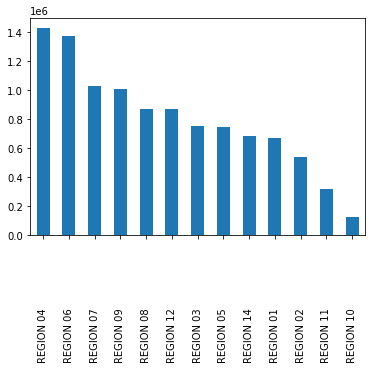

In [8]:
input_data_copy.RegionName.value_counts().plot(kind='bar') 
## number of observations per region

In [9]:
input_data_copy.sort_values(by=['EffectiveDate'], ascending=True,inplace=True)

In [10]:
input_data_copy['RegionName'] = input_data_copy['RegionName'].str.replace(r"[\"\',< ]", '')
input_data_copy['ProductCategory_Desc'] = input_data_copy['ProductCategory_Desc'].str.replace(r"[\"\',< ]", '')
cols = ['ProductCategory_Nbl', 'ProductCategory_Desc']
input_data_copy['eq_nm'] = input_data_copy[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

In [11]:
input_data_copy.head()

,DRKey,Division,EffectiveDate,ProductCategory_Nbl,ProductCategory_Desc,OnRent,QtyOwned,Rental,IHSRentalMarket,AvgTemp,AvgPrcp,Region,RegionName,eq_nm
0,103-1060,103,2016-01-01,1060,CONCRETEFLOORGRINDERS,0,16,1946.00,1.98,33.63,0.00,1,REGION01,1060_CONCRETEFLOORGRINDERS
8704333,708-7705,708,2016-01-01,7705,SKIDSTEERLOADER1500-2100LBTRACK,21,36,77778.50,4.54,47.89,0.08,12,REGION12,7705_SKIDSTEERLOADER1500-2100LBTRACK
7710503,608-5305,608,2016-01-01,5305,STRAIGHTBOOM40-49,40,72,83919.00,3.15,24.32,0.00,900,REGION09,5305_STRAIGHTBOOM40-49
6726467,408-7585,408,2016-01-01,7585,RIDE-ONVIBRATORYROLLERSSMOOTHDRUM,3,7,3660.00,0.85,50.84,0.25,400,REGION04,7585_RIDE-ONVIBRATORYROLLERSSMOOTHDRUM
6335770,405-2935,405,2016-01-01,2935,FORKLIFT-INDUSTRIAL10000LB,5,6,8750.00,1.09,39.40,0.00,400,REGION04,2935_FORKLIFT-INDUSTRIAL10000LB


In [12]:
use_region = ['REGION04','REGION06','REGION07','REGION09','REGION08','REGION12','REGION03','REGION05','REGION14','REGION02','REGION11']
input_data_copy = input_data_copy[input_data_copy.RegionName.isin(use_region)]

In [13]:
input_data_copy.head()

,DRKey,Division,EffectiveDate,ProductCategory_Nbl,ProductCategory_Desc,OnRent,QtyOwned,Rental,IHSRentalMarket,AvgTemp,AvgPrcp,Region,RegionName,eq_nm
8704333,708-7705,708,2016-01-01,7705,SKIDSTEERLOADER1500-2100LBTRACK,21,36,77778.50,4.54,47.89,0.08,12,REGION12,7705_SKIDSTEERLOADER1500-2100LBTRACK
7710503,608-5305,608,2016-01-01,5305,STRAIGHTBOOM40-49,40,72,83919.00,3.15,24.32,0.00,900,REGION09,5305_STRAIGHTBOOM40-49
6726467,408-7585,408,2016-01-01,7585,RIDE-ONVIBRATORYROLLERSSMOOTHDRUM,3,7,3660.00,0.85,50.84,0.25,400,REGION04,7585_RIDE-ONVIBRATORYROLLERSSMOOTHDRUM
6335770,405-2935,405,2016-01-01,2935,FORKLIFT-INDUSTRIAL10000LB,5,6,8750.00,1.09,39.40,0.00,400,REGION04,2935_FORKLIFT-INDUSTRIAL10000LB
7608150,607-5545,607,2016-01-01,5545,DUCTJACKS/GENIEMATERIALLIFTS,2,15,2574.00,1.41,30.63,0.02,600,REGION06,5545_DUCTJACKS/GENIEMATERIALLIFTS


In [14]:
feature_importance = [col for col in input_data_copy.columns if col not in ['Region','DRKey','clean_time','Rental', 'QtyOwned', "ProductCategory_Nbl","ProductCategory_Desc"]]

In [15]:
sg_district_elect=input_data_copy.copy()
sg_district_elect_train=sg_district_elect[feature_importance]
sg_district_elect_train.drop(sg_district_elect_train.loc[sg_district_elect_train[date_column] < '2015-05-01 00:00:00'].index, inplace=True) # prob dont need because data is from 2016
sg_district_elect_train.drop(sg_district_elect_train.loc[sg_district_elect_train[date_column] > '2020-05-01 01:00:00'].index, inplace=True)

In [16]:
sg_district_elect_train.tail()

,Division,EffectiveDate,OnRent,IHSRentalMarket,AvgTemp,AvgPrcp,RegionName,eq_nm
2320288,502,2020-04-30,20,3.45,73.94,0.72,REGION05,5245_MANLIFTARTICULATING80-89COMBUSTION
10401006,906,2020-04-30,4,3.36,46.97,1.32,REGION09,6145_MINI-EXCAVATOR2000LB-3500LB
6283056,404,2020-04-30,2,0.63,65.15,0.88,REGION04,730_BACKHOEEXTENDAHOE
4039430,711,2020-04-30,6,3.01,67.05,0.42,REGION12,2395_ROTARYANDDEMOLITIONHAMMERS
3697630,1402,2020-04-30,6,2.15,58.36,0.55,REGION14,1840_RIDE-ONASPHALTROLLERS


In [17]:
sg_training=sg_district_elect_train
split_date = '2019-5-20'
train = sg_district_elect_train.loc[sg_district_elect_train[date_column] <= split_date]
test = sg_district_elect_train.loc[sg_district_elect_train[date_column] > split_date]
print(f"{len(train)} days of training data \n {len(test)} days of testing data ")

5267907 days of training data 
 1450646 days of testing data 


In [18]:
train.head()

,Division,EffectiveDate,OnRent,IHSRentalMarket,AvgTemp,AvgPrcp,RegionName,eq_nm
8704333,708,2016-01-01,21,4.54,47.89,0.08,REGION12,7705_SKIDSTEERLOADER1500-2100LBTRACK
7710503,608,2016-01-01,40,3.15,24.32,0.00,REGION09,5305_STRAIGHTBOOM40-49
6726467,408,2016-01-01,3,0.85,50.84,0.25,REGION04,7585_RIDE-ONVIBRATORYROLLERSSMOOTHDRUM
6335770,405,2016-01-01,5,1.09,39.40,0.00,REGION04,2935_FORKLIFT-INDUSTRIAL10000LB
7608150,607,2016-01-01,2,1.41,30.63,0.02,REGION06,5545_DUCTJACKS/GENIEMATERIALLIFTS


In [19]:
train[date_column].min(), train[date_column].max()

(Timestamp('2016-01-01 00:00:00'), Timestamp('2019-05-20 00:00:00'))

In [20]:
test[date_column].min(), test[date_column].max()

(Timestamp('2019-05-21 00:00:00'), Timestamp('2020-04-30 00:00:00'))

In [21]:
from azureml.data.dataset_factory import TabularDatasetFactory

datastore = ws.get_default_datastore()
train_dataset = TabularDatasetFactory.register_pandas_dataframe(
    train, target=(datastore, "dataset/"), name="OnRent_train"
)
test_dataset = TabularDatasetFactory.register_pandas_dataframe(
    test, target=(datastore, "dataset/"), name="OnRent_test"
)

2022-05-19:19:11:25,279 INFO     [datastore_client.py:908] <azureml.core.authentication.InteractiveLoginAuthentication object at 0x7f495dfc1850>


Validating arguments.
Arguments validated.
Successfully obtained datastore reference and path.
Uploading file to dataset//3c289e7f-5bb2-4017-bb31-771244601020/
Successfully uploaded file to datastore.
Creating and registering a new dataset.
Successfully created and registered a new dataset.
Validating arguments.
Arguments validated.
Successfully obtained datastore reference and path.
Uploading file to dataset//98aeaf60-de69-4515-bdbf-cee38cf51cdb/
Successfully uploaded file to datastore.
Creating and registering a new dataset.
Successfully created and registered a new dataset.


In [22]:
from azureml.train.automl.runtime._hts.hts_parameters import HTSTrainParameters

model_explainability = True

engineered_explanations = False
# Define your hierarchy. Adjust the settings below based on your dataset.
hierarchy = ["RegionName", "Division", "eq_nm"]
training_level = "eq_nm"

# Set your forecast parameters. Adjust the settings below based on your dataset.
time_column_name = "EffectiveDate"
label_column_name = "OnRent"
forecast_horizon = 120


automl_settings = {
    "task": "forecasting",
    "primary_metric": "normalized_root_mean_squared_error",
    "label_column_name": label_column_name,
    "time_column_name": time_column_name,
    "forecast_horizon": forecast_horizon,
    "hierarchy_column_names": hierarchy,
    "hierarchy_training_level": training_level,
    "track_child_runs": False,
    "pipeline_fetch_max_batch_size": 15,
    "model_explainability": model_explainability,
    # The following settings are specific to this sample and should be adjusted according to your own needs.
    "iteration_timeout_minutes": 15,
    "iterations": 10,
    "n_cross_validations": 2,
}

hts_parameters = HTSTrainParameters(
    automl_settings=automl_settings,
    hierarchy_column_names=hierarchy,
    training_level=training_level,
    enable_engineered_explanations=engineered_explanations,
)

In [23]:
## Create Compute 

In [24]:
from azureml.core.compute import ComputeTarget, AmlCompute

# Name your cluster
compute_name = "hts-compute"


if compute_name in ws.compute_targets:
    compute_target = ws.compute_targets[compute_name]
    if compute_target and type(compute_target) is AmlCompute:
        print("Found compute target: " + compute_name)
else:
    print("Creating a new compute target...")
    provisioning_config = AmlCompute.provisioning_configuration(
        vm_size="Standard_D32_v3", max_nodes=300
    )
    # Create the compute target
    compute_target = ComputeTarget.create(ws, compute_name, provisioning_config)

    # Can poll for a minimum number of nodes and for a specific timeout.
    # If no min node count is provided it will use the scale settings for the cluster
    compute_target.wait_for_completion(
        show_output=True, min_node_count=None, timeout_in_minutes=20
    )

    # For a more detailed view of current cluster status, use the 'status' property
    print(compute_target.status.serialize())

Found compute target: hts-compute


In [25]:
training_pipeline_steps = AutoMLPipelineBuilder.get_many_models_train_steps(
    experiment=experiment,
    train_data=train_dataset,
    compute_target=compute_target,
    node_count=8,
    process_count_per_node=10,
    train_pipeline_parameters=hts_parameters,
)

2022-05-19:19:11:52,336 INFO     [automl_base_settings.py:591] Disabling Stack Ensemble by default for TimeSeries task,                     to avoid any overfitting when validation dataset is small.
2022-05-19:19:11:52,677 WARNING  [_docstring_wrapper.py:27] Class LinkTabularOutputDatasetConfig: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.


A partitioned tabular dataset will be created with the name training after hts_raw_partitioned_1652987512. You may use it for future training.


2022-05-19:19:11:53,229 INFO     [datastore_client.py:908] <azureml.core.authentication.InteractiveLoginAuthentication object at 0x7f495dfc1850>


Aggregation dataset is created with the name hts_agg_1652987512


In [26]:
from azureml.pipeline.core import Pipeline

training_pipeline = Pipeline(ws, steps=training_pipeline_steps)

2022-05-19:19:11:53,835 INFO     [datastore_client.py:908] <azureml.core.authentication.InteractiveLoginAuthentication object at 0x7f495dfc1850>


In [27]:
training_run = experiment.submit(training_pipeline)
training_run.wait_for_completion(show_output=False)

Created step hts-training-dataset-partition [539729d1][d3ae44d0-b9a4-4f61-8cbf-625cac26e87e], (This step will run and generate new outputs)
Created step hts-hierarchy-builder [7e788acb][d0e7dbb2-0462-4c6a-86d0-d1c6e8057c09], (This step will run and generate new outputs)
Created step hts-data-aggregation [2ff58798][ce51ac6b-274e-4fc2-81b2-469fd8a449af], (This step will run and generate new outputs)
Created step hts-automl-training [b69a52db][e9b1e76b-b592-473f-888f-3aae2ddc4892], (This step will run and generate new outputs)
Created step hts-proportions-calculation [e1fde60d][c0e53b2d-cb4e-4397-86b4-5db201e390bc], (This step will run and generate new outputs)
Created step hts-explanation-allocation [401b4d82][0ec3ae23-70c5-4fc4-97f4-0f36728dc6d5], (This step will run and generate new outputs)
Submitted PipelineRun 9df35d01-4b15-488a-8262-bd97fb60d0d0
Link to Azure Machine Learning Portal: https://ml.azure.com/runs/9df35d01-4b15-488a-8262-bd97fb60d0d0?wsid=/subscriptions/bbb69d60-fc2a-41

2022-05-19:20:26:53,936 WARNING  [connectionpool.py:780] Retrying (Retry(total=2, connect=2, read=3, redirect=None, status=None)) after connection broken by 'NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f46ef643220>: Failed to establish a new connection: [Errno 111] Connection refused')': /pipelines/v1.0/subscriptions/bbb69d60-fc2a-412b-822e-6b5c5dbd12ce/resourceGroups/azdatasciencerg/providers/Microsoft.MachineLearningServices/workspaces/tmazworkspace/PipelineRuns/9df35d01-4b15-488a-8262-bd97fb60d0d0


{'runId': '9df35d01-4b15-488a-8262-bd97fb60d0d0', 'status': 'Failed', 'startTimeUtc': '2022-05-19T19:12:11.857376Z', 'endTimeUtc': '2022-05-19T20:34:11.163068Z', 'services': {}, 'properties': {'azureml.runsource': 'azureml.PipelineRun', 'runSource': 'SDK', 'runType': 'SDK', 'azureml.parameters': '{"process_count_param":"10","batch_size_param":"1"}', 'azureml.continue_on_step_failure': 'False', 'azureml.pipelineComponent': 'pipelinerun', 'hts_run_type': 'training', 'hts_settings': '{"task": "forecasting", "primary_metric": "normalized_root_mean_squared_error", "label_column_name": "OnRent", "time_column_name": "EffectiveDate", "forecast_horizon": 120, "hierarchy_column_names": ["RegionName", "Division", "eq_nm"], "hierarchy_training_level": "eq_nm", "track_child_runs": false, "pipeline_fetch_max_batch_size": 15, "model_explainability": true, "iteration_timeout_minutes": 15, "iterations": 10, "n_cross_validations": 2}'}, 'inputDatasets': [], 'outputDatasets': [], 'logFiles': {'logs/azure

'Failed'

In [ ]:
if model_explainability:
    expl_output = training_run.get_pipeline_output("explanations")
    expl_output.download("training_explanations")
else:
    print(
        "Model explanations are available only if model_explainability is set to True."
    )

In [ ]:
import os

if model_explainability:
    explanations_dirrectory = os.listdir(
        os.path.join("training_explanations", "azureml")
    )
    if len(explanations_dirrectory) > 1:
        print(
            "Warning! The directory contains multiple explanations, only the first one will be displayed."
        )
    print("The explanations are located at {}.".format(explanations_dirrectory[0]))
    # Now we will list all the explanations.
    explanation_path = os.path.join(
        "training_explanations",
        "azureml",
        explanations_dirrectory[0],
        "training_explanations",
    )
    print("Available explanations")
    print("==============================")
    print("\n".join(os.listdir(explanation_path)))
else:
    print(
        "Model explanations are available only if model_explainability is set to True."
    )

In [ ]:
from IPython.display import display

explanation_type = "raw"
level = "Division"

if model_explainability:
    display(
        pd.read_csv(
            os.path.join(explanation_path, "{}_explanations_{}.csv").format(
                explanation_type, level
            )
        )
    )

In [ ]:
from azureml.train.automl.runtime._hts.hts_parameters import HTSInferenceParameters

inference_parameters = HTSInferenceParameters(
    hierarchy_forecast_level="eq_nm", # set to division later to find demand onwards # The setting is specific to this dataset and should be changed based on your dataset.
    allocation_method="bottom_up",
)

steps = AutoMLPipelineBuilder.get_many_models_batch_inference_steps(
    experiment=experiment,
    inference_data=test_dataset,
    compute_target=compute_target,
    inference_pipeline_parameters=inference_parameters,
    node_count=10,
    process_count_per_node=5,
)
from azureml.pipeline.core import Pipeline

inference_pipeline = Pipeline(ws, steps=steps)
inference_run = experiment.submit(inference_pipeline)
inference_run.wait_for_completion(show_output=False)

In [ ]:
forecasts = inference_run.get_pipeline_output("forecasts")
forecasts.download("forecast_results")

In [ ]:
inference_run = experiment.submit(
    inference_pipeline, pipeline_parameters={"hierarchy_forecast_level": "eq_nm"}
)
inference_run.wait_for_completion(show_output=False)

In [ ]:
# run this last for this stuff
forecasts = inference_run.get_pipeline_output("forecasts")
forecasts.download("forecast_results")